In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [2]:
# Importing the training and testing sets
%run "./Data Splitting.ipynb"

In [3]:
# Retreiving the different types of offers
subscriptions = df["IN_SUBSCRIPTION_TYPE"].unique()
subscriptions

array([-1.,  1.,  2.,  3.,  4.,  6.,  7.,  8.,  5.,  9.])

In [4]:
# Grouping the offers with the ones that generate approximately the same revenue
empty_subscription = np.array([-1])
subscriptions_1_2 = np.array([1,2])
subscriptions_3 = np.array([3])
subscriptions_6 = np.array([6])
other_subscriptions = np.array([4,5,7,8,9])

In [5]:
# seperating all the dfs by subscriptions
grouped_df = df.groupby(["IN_SUBSCRIPTION_TYPE","REPORT_DATE"]).agg({
    "REVENUE":"sum",
    "IS_CODE6_ENABLED":"first",
}).reset_index()

empty_subscription_df =  grouped_df[grouped_df["IN_SUBSCRIPTION_TYPE"].isin(empty_subscription)].drop(columns=["IN_SUBSCRIPTION_TYPE"]).reset_index(drop=True)
subscriptions_1_2_df = grouped_df[grouped_df["IN_SUBSCRIPTION_TYPE"].isin(subscriptions_1_2)].groupby(["REPORT_DATE"]).agg({
    "REVENUE":"sum",
    "IS_CODE6_ENABLED":"first",
}).reset_index()
subscriptions_3_df = grouped_df[grouped_df["IN_SUBSCRIPTION_TYPE"].isin(subscriptions_3)].drop(columns=["IN_SUBSCRIPTION_TYPE"]).reset_index(drop=True)
subscriptions_6_df = grouped_df[grouped_df["IN_SUBSCRIPTION_TYPE"].isin(subscriptions_6)].drop(columns=["IN_SUBSCRIPTION_TYPE"]).reset_index(drop=True)
other_subscriptions_df = grouped_df[grouped_df["IN_SUBSCRIPTION_TYPE"].isin(other_subscriptions)].groupby(["REPORT_DATE"]).agg({
    "REVENUE":"sum",
    "IS_CODE6_ENABLED":"first",
}).reset_index()


In [6]:
empty_subscription_df.shape,subscriptions_1_2_df.shape,subscriptions_3_df.shape,subscriptions_6_df.shape,other_subscriptions_df.shape

((729, 3), (729, 3), (729, 3), (729, 3), (729, 3))

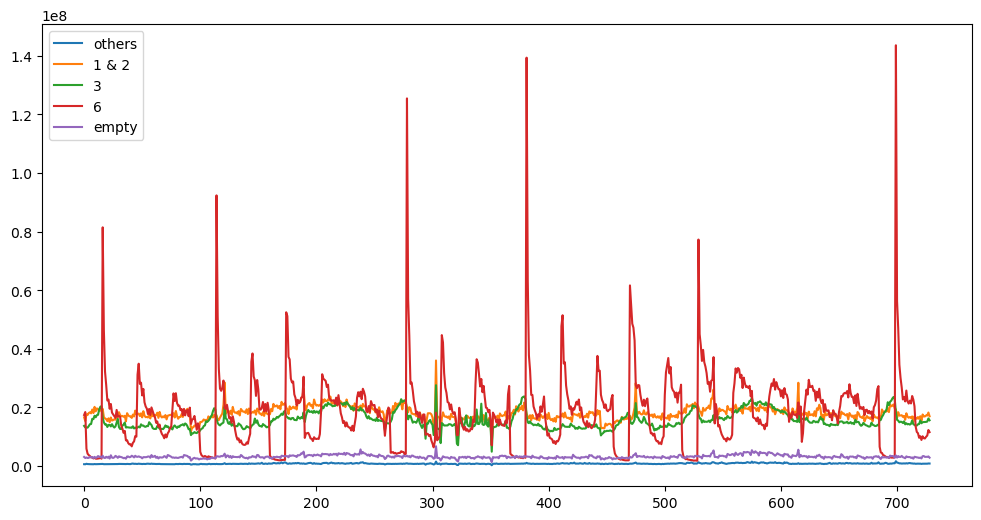

In [8]:
# Plotting the revenues 
plt.figure(figsize=(12, 6))

other_subscriptions_df["REVENUE"].plot(label="others")
subscriptions_1_2_df["REVENUE"].plot(label="1 & 2")
subscriptions_3_df["REVENUE"].plot(label="3")
subscriptions_6_df["REVENUE"].plot(label="6")
empty_subscription_df["REVENUE"].plot(label="empty")

plt.legend()

In [9]:
# Importing the necessary libraries for the training and standarization
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Input
from tensorflow.keras.optimizers import Adam

# Importing the libraries to save the scalers for later use
import pickle

In [79]:
from tensorflow.keras.callbacks import EarlyStopping

# Define the EarlyStopping callback to be able to not train non performant models
early_stopping = EarlyStopping(
    monitor='val_loss',  
    patience=50,    
    min_delta=0.00001,
    verbose=2,           
    restore_best_weights=True,
    baseline=None,
    mode='min'
)

# LSTM of offers : 
<h1 style="color:red;">1 and 2</h1>

In [12]:
# Defining the grouped_df to be used here which is the 1_2 dataframe
grouped_df = subscriptions_1_2_df

# Adding the lag
for i in range(1, 31):
    grouped_df[f'REVENUE_LAG_{i}'] = grouped_df['REVENUE'].shift(i)
    grouped_df[f'IS_CODE6_ENABLED_{i}'] = grouped_df['IS_CODE6_ENABLED'].shift(i).astype(float)
grouped_df.dropna(inplace=True); grouped_df.reset_index(drop=True,inplace=True)

# Splitting the new lagged dataFrame for training and testing
group_split_value = int(len(grouped_df)*0.8)

df_train = grouped_df.iloc[:group_split_value]
df_test = grouped_df.iloc[group_split_value:]

X_train = df_train.drop(columns=["REPORT_DATE","REVENUE"]).values
y_train = df_train["REVENUE"].values.reshape(-1, 1)

X_test = df_test.drop(columns=["REPORT_DATE","REVENUE"]).values
y_test = df_test["REVENUE"].values.reshape(-1, 1)

In [13]:
# Initialize the scaler for X
scaler_X = MinMaxScaler(feature_range=(0, 1))
X_train_scaled = scaler_X.fit_transform(X_train)
X_test_scaled = scaler_X.transform(X_test)

# Initialize the scaler for y which is not necessary
scaler_y = MinMaxScaler(feature_range=(0, 1))
y_train_scaled = scaler_y.fit_transform(y_train)
y_test_scaled = scaler_y.transform(y_test)

# Saving the scalers
scalers = {'scaler_X': scaler_X, 'scaler_y': scaler_y}

with open('../Scalers/scaler_1_2.pickle', 'wb') as f:
    pickle.dump(scalers, f)

In [14]:
# Reshaping the data to work with the tensors (3D)
X_train_reshaped = X_train_scaled.reshape((X_train.shape[0], 1, 61))
X_test_reshaped = X_test_scaled.reshape((X_test.shape[0], 1, 61))

In [15]:
# Defining the LSTM model
model_1_2 = Sequential()
model_1_2.add(Input(shape=(X_train_reshaped.shape[1], X_train_reshaped.shape[2])))
model_1_2.add(LSTM(68, return_sequences=True))  
model_1_2.add(Dropout(0.1))   
model_1_2.add(LSTM(68, return_sequences=True)) 
model_1_2.add(Dropout(0.1))  
model_1_2.add(LSTM(36, return_sequences=True)) 
model_1_2.add(Dropout(0.1))  
model_1_2.add(LSTM(16, return_sequences=False)) 
model_1_2.add(Dense(1))
model_1_2.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (None, 1, 68)               │          35,360 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 1, 68)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 1, 68)               │          37,264 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 1, 68)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_2 (LSTM)                        │ (None, 1, 36)               │          15,120 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 1, 36)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_3 (LSTM)                        │ (None, 16)                  │           3,392 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1)                   │              17 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 91,153 (356.07 KB)

 Trainable params: 91,153 (356.07 KB)

 Non-trainable params: 0 (0.00 B)

In [16]:
# Compile the model
model_1_2.compile(optimizer=Adam(learning_rate=0.0005), loss='mean_absolute_error')

# Fit the model
history_1_2 = model_1_2.fit(X_train_reshaped, y_train_scaled, epochs=400, batch_size=4, validation_data=(X_test_reshaped, y_test_scaled),callbacks=[early_stopping], verbose=1)

Epoch 1/400
140/140 ━━━━━━━━━━━━━━━━━━━━ 12s 16ms/step - loss: 0.2254 - val_loss: 0.0466
Epoch 2/400
140/140 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0719 - val_loss: 0.0370
Epoch 3/400
140/140 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0602 - val_loss: 0.0517
Epoch 4/400
140/140 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0575 - val_loss: 0.0362
Epoch 5/400
140/140 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0456 - val_loss: 0.0338
Epoch 6/400
140/140 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0483 - val_loss: 0.0482
Epoch 7/400
140/140 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0493 - val_loss: 0.0338
Epoch 8/400
140/140 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0451 - val_loss: 0.0333
Epoch 9/400
140/140 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0476 - val_loss: 0.0331
Epoch 10/400
140/140 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0454 - val_loss: 0.0322
Epoch 11/400
140/140 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0431 - val_loss: 0.0300
Epoch 12/400
140/140 ━━━━━━━━━━━━━━━━━

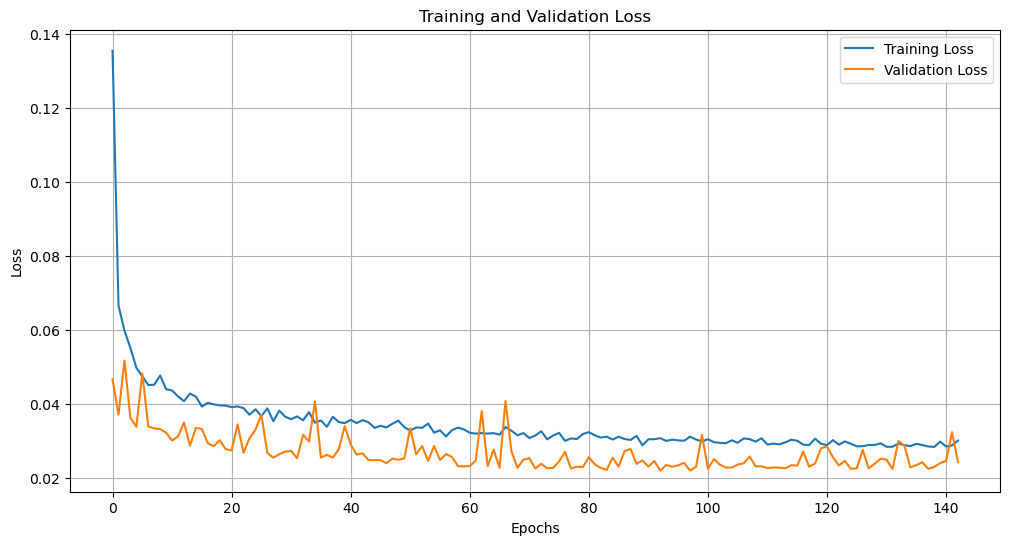

In [23]:
# Checking if there is a overfitting

history_dict = history_1_2.history
loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']

plt.figure(figsize=(12, 6))
plt.plot(loss_values, label='Training Loss')
plt.plot(val_loss_values, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

In [24]:
# Making the dataframe of predictions

y_pred = scaler_y.inverse_transform(model_1_2.predict(X_test_reshaped))
abs_diff = np.abs((y_pred.reshape(-1) - y_test.reshape(-1)))

data_1_2 = pd.DataFrame({
    "test":y_test.reshape(-1),
    "pred":y_pred.reshape(-1),
    "diff_val_by_million":abs_diff/1e6,
    "diff_percentage": abs_diff / y_test.reshape(-1) * 100
})

data_1_2

5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 243ms/step


,test,pred,diff_val_by_million,diff_percentage
0,20413232.0,19800288.0,0.612944,3.002680
1,20513437.0,19164832.0,1.348605,6.574252
2,20025826.0,19513292.0,0.512534,2.559365
3,19861678.0,19772268.0,0.089410,0.450163
4,18612033.0,18857382.0,0.245349,1.318228
...,...,...,...,...
135,16927325.0,17214030.0,0.286705,1.693741
136,17288519.0,17375260.0,0.086741,0.501726
137,17239755.0,16784656.0,0.455099,2.639823
138,18269577.0,17949424.0,0.320153,1.752383


count    140.000000
mean       3.406934
std        4.340962
min        0.006111
25%        0.785660
50%        2.213230
75%        4.250471
max       33.930806
Name: diff_percentage, dtype: float64


<Axes: >

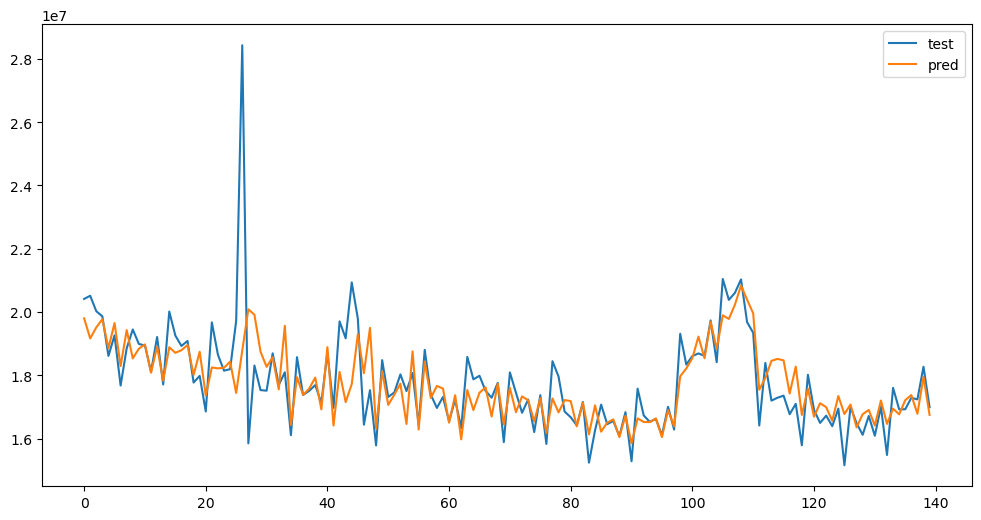

In [31]:
print(data_1_2["diff_percentage"].describe())

data_1_2[["test","pred"]].plot(figsize=(12, 6))

In [36]:
# Saving the model

model_1_2.save('../Saved Models/m_1_2.keras')

# LSTM of offers : 
<h1 style="color:red;">empty</h1>

In [39]:
# Defining the grouped_df to be used here which is the 1_2 dataframe
grouped_df = empty_subscription_df

# Adding the lag
for i in range(1, 31):
    grouped_df[f'REVENUE_LAG_{i}'] = grouped_df['REVENUE'].shift(i)
    grouped_df[f'IS_CODE6_ENABLED_{i}'] = grouped_df['IS_CODE6_ENABLED'].shift(i).astype(float)
grouped_df.dropna(inplace=True); grouped_df.reset_index(drop=True,inplace=True)

# Splitting the new lagged dataFrame for training and testing
group_split_value = int(len(grouped_df)*0.8)

df_train = grouped_df.iloc[:group_split_value]
df_test = grouped_df.iloc[group_split_value:]

X_train = df_train.drop(columns=["REPORT_DATE","REVENUE"]).values
y_train = df_train["REVENUE"].values.reshape(-1, 1)

X_test = df_test.drop(columns=["REPORT_DATE","REVENUE"]).values
y_test = df_test["REVENUE"].values.reshape(-1, 1)

In [41]:
# Initialize the scaler for X
scaler_X = MinMaxScaler(feature_range=(0, 1))
X_train_scaled = scaler_X.fit_transform(X_train)
X_test_scaled = scaler_X.transform(X_test)

# Initialize the scaler for y which is not necessary
scaler_y = MinMaxScaler(feature_range=(0, 1))
y_train_scaled = scaler_y.fit_transform(y_train)
y_test_scaled = scaler_y.transform(y_test)

# Saving the scalers
scalers = {'scaler_X': scaler_X, 'scaler_y': scaler_y}

with open('../Scalers/scaler_empty.pickle', 'wb') as f:
    pickle.dump(scalers, f)

In [43]:
# Reshaping the data to work with the tensors (3D)
X_train_reshaped = X_train_scaled.reshape((X_train.shape[0], 1, 61))
X_test_reshaped = X_test_scaled.reshape((X_test.shape[0], 1, 61))

In [45]:
# Defining the LSTM model
model_empty= Sequential()
model_empty.add(Input(shape=(X_train_reshaped.shape[1], X_train_reshaped.shape[2])))
model_empty.add(LSTM(500, return_sequences=True))  
model_empty.add(Dropout(0.1))  
model_empty.add(LSTM(500, return_sequences=True))  
model_empty.add(Dropout(0.1))  
model_empty.add(LSTM(300, return_sequences=True))  
model_empty.add(Dropout(0.1))  
model_empty.add(LSTM(300, return_sequences=True)) 
model_empty.add(Dropout(0.1)) 
model_empty.add(LSTM(300, return_sequences=False)) 
model_empty.add(Dense(1))
model_empty.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_4 (LSTM)                        │ (None, 1, 500)              │       1,124,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 1, 500)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_5 (LSTM)                        │ (None, 1, 500)              │       2,002,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 1, 500)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_6 (LSTM)                        │ (None, 1, 300)              │         961,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 1, 300)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_7 (LSTM)                        │ (None, 1, 300)              │         721,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_6 (Dropout)                  │ (None, 1, 300)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_8 (LSTM)                        │ (None, 300)                 │         721,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │             301 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 5,529,901 (21.09 MB)

 Trainable params: 5,529,901 (21.09 MB)

 Non-trainable params: 0 (0.00 B)

In [86]:
# Compile the model
model_empty.compile(optimizer=Adam(learning_rate=0.0005), loss='mean_absolute_error')

# Fit the model
history_empty = model_empty.fit(X_train_reshaped, y_train_scaled, epochs=100, batch_size=16, validation_data=(X_test_reshaped, y_test_scaled),callbacks=None, verbose=1)

Epoch 1/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 17s 143ms/step - loss: 0.0521 - val_loss: 0.0373
Epoch 2/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 4s 106ms/step - loss: 0.0445 - val_loss: 0.0433
Epoch 3/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 4s 103ms/step - loss: 0.0447 - val_loss: 0.0390
Epoch 4/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 4s 104ms/step - loss: 0.0438 - val_loss: 0.0416
Epoch 5/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 4s 106ms/step - loss: 0.0442 - val_loss: 0.0442
Epoch 6/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 5s 101ms/step - loss: 0.0421 - val_loss: 0.0401
Epoch 7/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 4s 104ms/step - loss: 0.0448 - val_loss: 0.0395
Epoch 8/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 4s 101ms/step - loss: 0.0412 - val_loss: 0.0363
Epoch 9/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 5s 106ms/step - loss: 0.0414 - val_loss: 0.0360
Epoch 10/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 4s 102ms/step - loss: 0.0458 - val_loss: 0.0395
Epoch 11/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 4s 102ms/step - loss: 0.0396 - val_loss: 0.0386
Epoch 12/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 

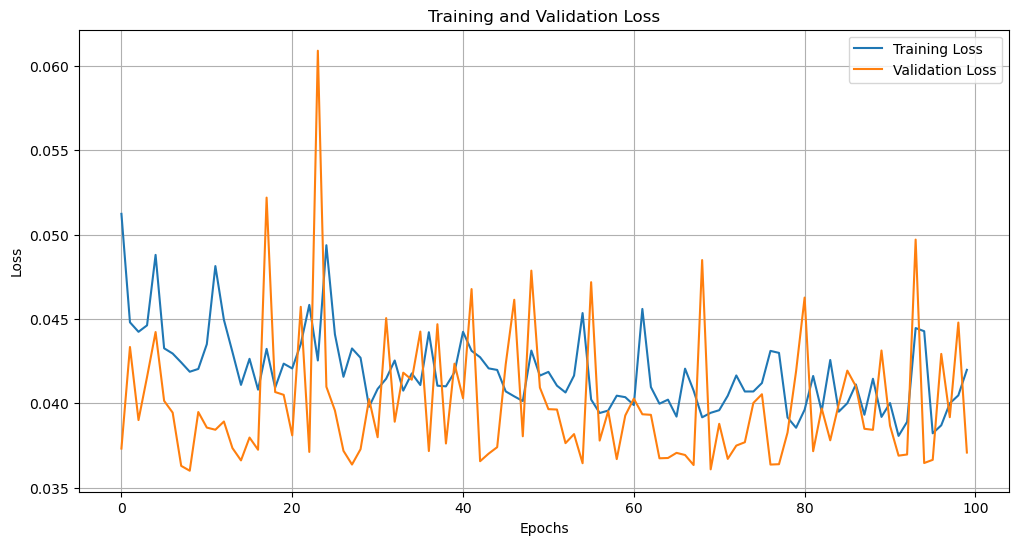

In [87]:
# Checking if there is a overfitting

history_dict = history_empty.history
loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']

plt.figure(figsize=(12, 6))
plt.plot(loss_values, label='Training Loss')
plt.plot(val_loss_values, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

In [88]:
# Making the dataframe of predictions

y_pred = scaler_y.inverse_transform(model_empty.predict(X_test_reshaped))
abs_diff = np.abs((y_pred.reshape(-1) - y_test.reshape(-1)))

data_empty = pd.DataFrame({
    "test":y_test.reshape(-1),
    "pred":y_pred.reshape(-1),
    "diff_val_by_million":abs_diff/1e6,
    "diff_percentage": abs_diff / y_test.reshape(-1) * 100
})

data_empty

5/5 ━━━━━━━━━━━━━━━━━━━━ 4s 512ms/step


,test,pred,diff_val_by_million,diff_percentage
0,4665027.0,4635778.50,0.029249,0.626974
1,4767666.0,4190677.50,0.576989,12.102117
2,4447449.0,4316930.00,0.130519,2.934694
3,4513899.0,4460789.50,0.053109,1.176577
4,4217737.0,4235139.50,0.017403,0.412603
...,...,...,...,...
135,3122199.0,3191289.75,0.069091,2.212887
136,3160835.0,3061522.25,0.099313,3.141978
137,3138806.0,2744070.75,0.394735,12.575968
138,3288562.0,3083748.75,0.204813,6.228049


count    140.000000
mean       5.925250
std        5.570580
min        0.049916
25%        2.107015
50%        4.496936
75%        7.666052
max       38.222051
Name: diff_percentage, dtype: float64


<Axes: >

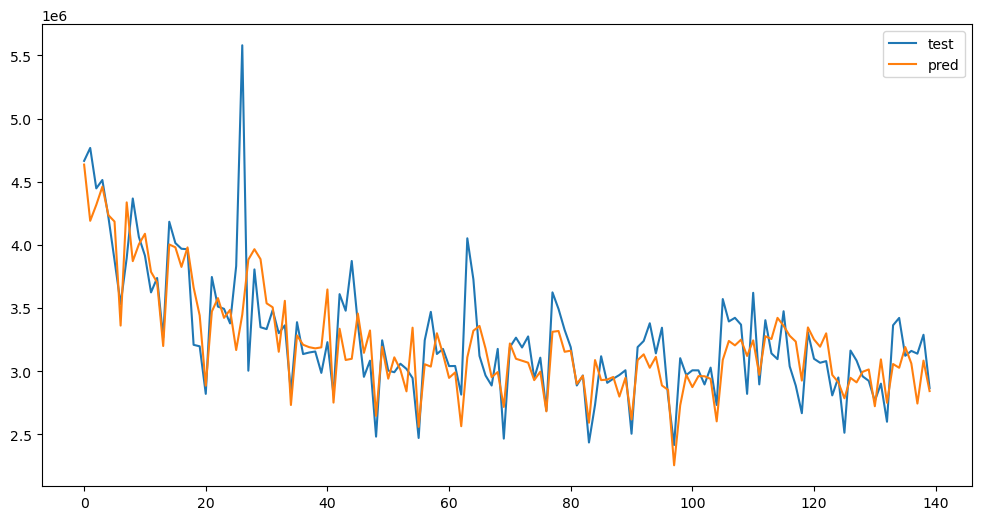

In [89]:
print(data_empty["diff_percentage"].describe())

data_empty[["test","pred"]].plot(figsize=(12, 6))

In [94]:
# Saving the model

model_empty.save('../Saved Models/m_empty.keras')

# LSTM of offers : 
<h1 style="color:red;">others</h1>

In [97]:
# Defining the grouped_df to be used here which is the other_subscritions dataframe
grouped_df = other_subscriptions_df

# Adding the lag
for i in range(1, 31):
    grouped_df[f'REVENUE_LAG_{i}'] = grouped_df['REVENUE'].shift(i)
    grouped_df[f'IS_CODE6_ENABLED_{i}'] = grouped_df['IS_CODE6_ENABLED'].shift(i).astype(float)
grouped_df.dropna(inplace=True); grouped_df.reset_index(drop=True,inplace=True)

# Splitting the new lagged dataFrame for training and testing
group_split_value = int(len(grouped_df)*0.8)

df_train = grouped_df.iloc[:group_split_value]
df_test = grouped_df.iloc[group_split_value:]

X_train = df_train.drop(columns=["REPORT_DATE","REVENUE"]).values
y_train = df_train["REVENUE"].values.reshape(-1, 1)

X_test = df_test.drop(columns=["REPORT_DATE","REVENUE"]).values
y_test = df_test["REVENUE"].values.reshape(-1, 1)

In [99]:
# Initialize the scaler for X
scaler_X = MinMaxScaler(feature_range=(0, 1))
X_train_scaled = scaler_X.fit_transform(X_train)
X_test_scaled = scaler_X.transform(X_test)

# Initialize the scaler for y which is not necessary
scaler_y = MinMaxScaler(feature_range=(0, 1))
y_train_scaled = scaler_y.fit_transform(y_train)
y_test_scaled = scaler_y.transform(y_test)

# Saving the scalers
scalers = {'scaler_X': scaler_X, 'scaler_y': scaler_y}

with open('../Scalers/scaler_others.pickle', 'wb') as f:
    pickle.dump(scalers, f)

In [101]:
# Reshaping the data to work with the tensors (3D)
X_train_reshaped = X_train_scaled.reshape((X_train.shape[0], 1, 61))
X_test_reshaped = X_test_scaled.reshape((X_test.shape[0], 1, 61))

In [103]:
# Defining the LSTM model
model_others= Sequential()
model_others.add(Input(shape=(X_train_reshaped.shape[1], X_train_reshaped.shape[2])))
model_others.add(LSTM(500, return_sequences=True))  
model_others.add(Dropout(0.1))  
model_others.add(LSTM(300, return_sequences=True)) 
model_others.add(Dropout(0.1)) 
model_others.add(LSTM(300, return_sequences=True)) 
model_others.add(Dropout(0.1)) 
model_others.add(LSTM(300, return_sequences=True)) 
model_others.add(Dropout(0.1)) 
model_others.add(LSTM(300, return_sequences=True)) 
model_others.add(Dropout(0.15))
model_others.add(LSTM(350, return_sequences=False)) 
model_others.add(Dense(1))
model_others.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_9 (LSTM)                        │ (None, 1, 500)              │       1,124,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_7 (Dropout)                  │ (None, 1, 500)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_10 (LSTM)                       │ (None, 1, 300)              │         961,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_8 (Dropout)                  │ (None, 1, 300)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_11 (LSTM)                       │ (None, 1, 300)              │         721,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_9 (Dropout)                  │ (None, 1, 300)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_12 (LSTM)                       │ (None, 1, 300)              │         721,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_10 (Dropout)                 │ (None, 1, 300)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_13 (LSTM)                       │ (None, 1, 300)              │         721,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_11 (Dropout)                 │ (None, 1, 300)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_14 (LSTM)                       │ (None, 350)                 │         911,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 1)                   │             351 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 5,160,551 (19.69 MB)

 Trainable params: 5,160,551 (19.69 MB)

 Non-trainable params: 0 (0.00 B)

In [105]:
# Compile the model
model_others.compile(optimizer=Adam(learning_rate=0.001), loss='mean_absolute_error')

# Fit the model
history_others = model_others.fit(X_train_reshaped, y_train_scaled, epochs=400, batch_size=8, validation_data=(X_test_reshaped, y_test_scaled),callbacks=[early_stopping], verbose=1)

Epoch 1/400
70/70 ━━━━━━━━━━━━━━━━━━━━ 24s 118ms/step - loss: 0.2437 - val_loss: 0.0811
Epoch 2/400
70/70 ━━━━━━━━━━━━━━━━━━━━ 6s 81ms/step - loss: 0.0878 - val_loss: 0.0808
Epoch 3/400
70/70 ━━━━━━━━━━━━━━━━━━━━ 7s 99ms/step - loss: 0.0876 - val_loss: 0.0724
Epoch 4/400
70/70 ━━━━━━━━━━━━━━━━━━━━ 7s 96ms/step - loss: 0.0814 - val_loss: 0.0739
Epoch 5/400
70/70 ━━━━━━━━━━━━━━━━━━━━ 7s 97ms/step - loss: 0.0846 - val_loss: 0.0793
Epoch 6/400
70/70 ━━━━━━━━━━━━━━━━━━━━ 7s 98ms/step - loss: 0.0765 - val_loss: 0.0700
Epoch 7/400
70/70 ━━━━━━━━━━━━━━━━━━━━ 7s 99ms/step - loss: 0.0694 - val_loss: 0.0864
Epoch 8/400
70/70 ━━━━━━━━━━━━━━━━━━━━ 7s 98ms/step - loss: 0.0686 - val_loss: 0.0662
Epoch 9/400
70/70 ━━━━━━━━━━━━━━━━━━━━ 7s 94ms/step - loss: 0.0632 - val_loss: 0.0782
Epoch 10/400
70/70 ━━━━━━━━━━━━━━━━━━━━ 7s 97ms/step - loss: 0.0769 - val_loss: 0.0779
Epoch 11/400
70/70 ━━━━━━━━━━━━━━━━━━━━ 7s 93ms/step - loss: 0.0656 - val_loss: 0.0689
Epoch 12/400
70/70 ━━━━━━━━━━━━━━━━━━━━ 7s 95ms/st

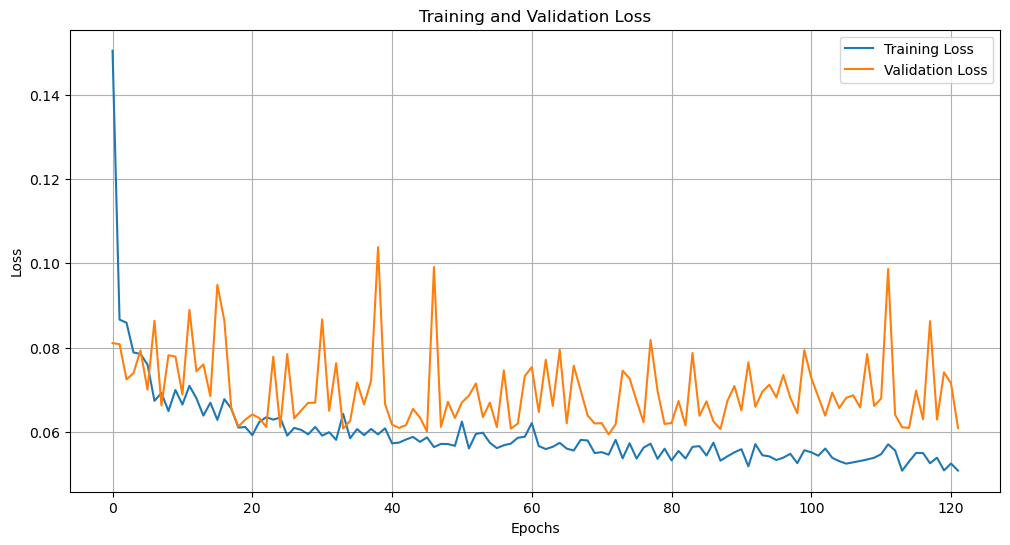

In [106]:
# Checking if there is a overfitting

history_dict = history_others.history
loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']

plt.figure(figsize=(12, 6))
plt.plot(loss_values, label='Training Loss')
plt.plot(val_loss_values, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

In [107]:
# Making the dataframe of predictions

y_pred = scaler_y.inverse_transform(model_others.predict(X_test_reshaped))
abs_diff = np.abs((y_pred.reshape(-1) - y_test.reshape(-1)))

data_others = pd.DataFrame({
    "test":y_test.reshape(-1),
    "pred":y_pred.reshape(-1),
    "diff_val_by_million":abs_diff/1e6,
    "diff_percentage": abs_diff / y_test.reshape(-1) * 100
})

data_others

5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 313ms/step


,test,pred,diff_val_by_million,diff_percentage
0,1016700.0,9.717049e+05,0.044995,4.425599
1,1147061.0,9.770323e+05,0.170029,14.822986
2,1200801.0,1.029996e+06,0.170805,14.224234
3,1140590.0,1.030135e+06,0.110455,9.684051
4,1149509.0,9.963523e+05,0.153157,13.323661
...,...,...,...,...
135,810533.0,8.153007e+05,0.004768,0.588216
136,830240.0,8.081292e+05,0.022111,2.663183
137,813926.0,8.017816e+05,0.012144,1.492081
138,884362.0,8.333369e+05,0.051025,5.769710


count    140.000000
mean       7.671028
std        7.293786
min        0.010302
25%        2.420497
50%        5.791022
75%       10.609474
max       41.520117
Name: diff_percentage, dtype: float64


<Axes: >

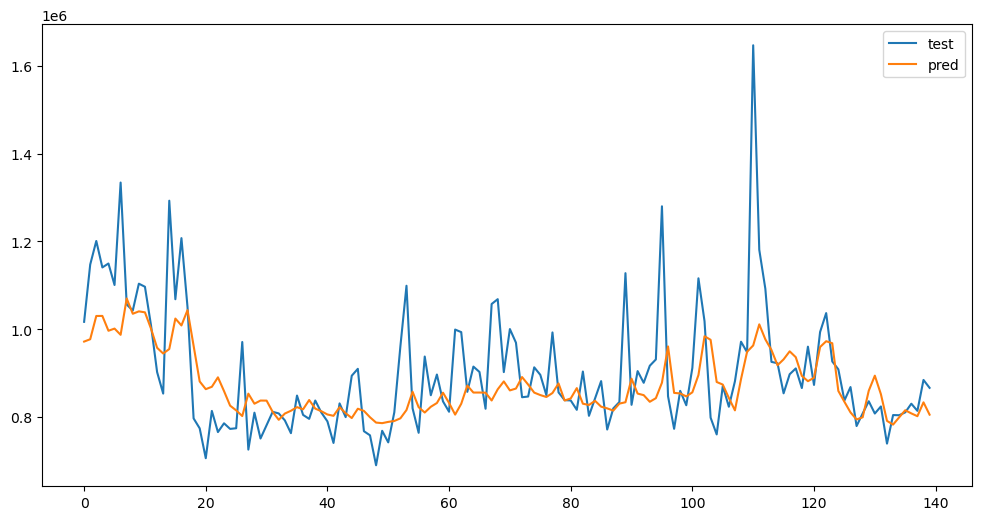

In [108]:
print(data_others["diff_percentage"].describe())

data_others[["test","pred"]].plot(figsize=(12, 6))

In [113]:
# Saving the model

model_others.save('../Saved Models/m_others.keras')

# LSTM of offers : 
<h1 style="color:red;">3</h1>

In [116]:
# Defining the grouped_df to be used here which is the subscription_3 dataframe
grouped_df = subscriptions_3_df

# Adding the lag
for i in range(1, 31):
    grouped_df[f'REVENUE_LAG_{i}'] = grouped_df['REVENUE'].shift(i)
    grouped_df[f'IS_CODE6_ENABLED_{i}'] = grouped_df['IS_CODE6_ENABLED'].shift(i).astype(float)
grouped_df.dropna(inplace=True); grouped_df.reset_index(drop=True,inplace=True)

# Splitting the new lagged dataFrame for training and testing
group_split_value = int(len(grouped_df)*0.8)

df_train = grouped_df.iloc[:group_split_value]
df_test = grouped_df.iloc[group_split_value:]

X_train = df_train.drop(columns=["REPORT_DATE","REVENUE"]).values
y_train = df_train["REVENUE"].values.reshape(-1, 1)

X_test = df_test.drop(columns=["REPORT_DATE","REVENUE"]).values
y_test = df_test["REVENUE"].values.reshape(-1, 1)

In [118]:
# Initialize the scaler for X
scaler_X = MinMaxScaler(feature_range=(0, 1))
X_train_scaled = scaler_X.fit_transform(X_train)
X_test_scaled = scaler_X.transform(X_test)

# Initialize the scaler for y which is not necessary
scaler_y = MinMaxScaler(feature_range=(0, 1))
y_train_scaled = scaler_y.fit_transform(y_train)
y_test_scaled = scaler_y.transform(y_test)

# Saving the scalers
scalers = {'scaler_X': scaler_X, 'scaler_y': scaler_y}

with open('../Scalers/scaler_3.pickle', 'wb') as f:
    pickle.dump(scalers, f)

In [120]:
# Reshaping the data to work with the tensors (3D)
X_train_reshaped = X_train_scaled.reshape((X_train.shape[0], 1, 61))
X_test_reshaped = X_test_scaled.reshape((X_test.shape[0], 1, 61))

In [122]:
# Defining the LSTM model
model_3= Sequential()
model_3.add(Input(shape=(X_train_reshaped.shape[1], X_train_reshaped.shape[2])))
model_3.add(LSTM(500, return_sequences=True))  
model_3.add(Dropout(0.1))  
model_3.add(LSTM(300, return_sequences=True)) 
model_3.add(Dropout(0.1)) 
model_3.add(LSTM(300, return_sequences=True)) 
model_3.add(Dropout(0.2))  
model_3.add(LSTM(300, return_sequences=True)) 
model_3.add(Dropout(0.15))
model_3.add(LSTM(350, return_sequences=False)) 
model_3.add(Dense(1))
model_3.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_15 (LSTM)                       │ (None, 1, 500)              │       1,124,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_12 (Dropout)                 │ (None, 1, 500)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_16 (LSTM)                       │ (None, 1, 300)              │         961,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_13 (Dropout)                 │ (None, 1, 300)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_17 (LSTM)                       │ (None, 1, 300)              │         721,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_14 (Dropout)                 │ (None, 1, 300)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_18 (LSTM)                       │ (None, 1, 300)              │         721,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_15 (Dropout)                 │ (None, 1, 300)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_19 (LSTM)                       │ (None, 350)                 │         911,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 1)                   │             351 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 4,439,351 (16.93 MB)

 Trainable params: 4,439,351 (16.93 MB)

 Non-trainable params: 0 (0.00 B)

In [124]:
# Compile the model
model_3.compile(optimizer=Adam(learning_rate=0.0005), loss='mean_absolute_error')

# Fit the model
history_3 = model_3.fit(X_train_reshaped, y_train_scaled, epochs=400, batch_size=8, validation_data=(X_test_reshaped, y_test_scaled),callbacks=[early_stopping], verbose=1)

Epoch 1/400
70/70 ━━━━━━━━━━━━━━━━━━━━ 20s 113ms/step - loss: 0.2779 - val_loss: 0.0630
Epoch 2/400
70/70 ━━━━━━━━━━━━━━━━━━━━ 5s 72ms/step - loss: 0.0862 - val_loss: 0.0592
Epoch 3/400
70/70 ━━━━━━━━━━━━━━━━━━━━ 6s 91ms/step - loss: 0.0732 - val_loss: 0.1016
Epoch 4/400
70/70 ━━━━━━━━━━━━━━━━━━━━ 6s 89ms/step - loss: 0.0810 - val_loss: 0.0513
Epoch 5/400
70/70 ━━━━━━━━━━━━━━━━━━━━ 10s 83ms/step - loss: 0.0629 - val_loss: 0.0869
Epoch 6/400
70/70 ━━━━━━━━━━━━━━━━━━━━ 6s 80ms/step - loss: 0.0711 - val_loss: 0.0421
Epoch 7/400
70/70 ━━━━━━━━━━━━━━━━━━━━ 5s 75ms/step - loss: 0.0556 - val_loss: 0.0501
Epoch 8/400
70/70 ━━━━━━━━━━━━━━━━━━━━ 5s 76ms/step - loss: 0.0546 - val_loss: 0.0357
Epoch 9/400
70/70 ━━━━━━━━━━━━━━━━━━━━ 5s 77ms/step - loss: 0.0583 - val_loss: 0.0445
Epoch 10/400
70/70 ━━━━━━━━━━━━━━━━━━━━ 5s 76ms/step - loss: 0.0550 - val_loss: 0.0355
Epoch 11/400
70/70 ━━━━━━━━━━━━━━━━━━━━ 5s 77ms/step - loss: 0.0535 - val_loss: 0.0465
Epoch 12/400
70/70 ━━━━━━━━━━━━━━━━━━━━ 5s 76ms/s

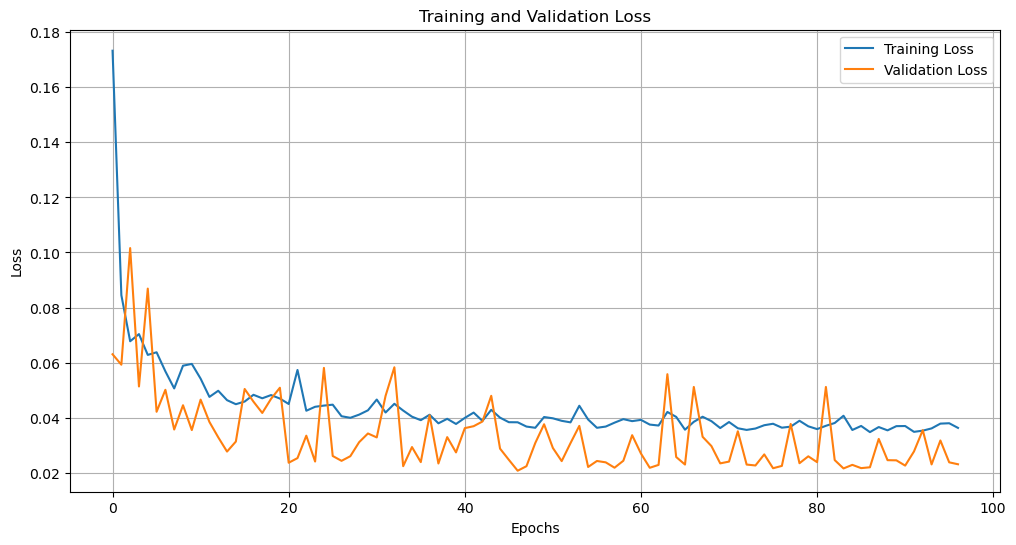

In [125]:
# Checking if there is a overfitting

history_dict = history_3.history
loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']

plt.figure(figsize=(12, 6))
plt.plot(loss_values, label='Training Loss')
plt.plot(val_loss_values, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

In [126]:
# Making the dataframe of predictions

y_pred = scaler_y.inverse_transform(model_3.predict(X_test_reshaped))
abs_diff = np.abs((y_pred.reshape(-1) - y_test.reshape(-1)))

data_3 = pd.DataFrame({
    "test":y_test.reshape(-1),
    "pred":y_pred.reshape(-1),
    "diff_val_by_million":abs_diff/1e6,
    "diff_percentage": abs_diff / y_test.reshape(-1) * 100
})

data_3

5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 265ms/step


,test,pred,diff_val_by_million,diff_percentage
0,21394223.0,21227028.0,0.167195,0.781496
1,21137938.0,21105158.0,0.032780,0.155077
2,21062921.0,21045094.0,0.017827,0.084637
3,20944361.0,20860172.0,0.084189,0.401965
4,19755915.0,20750480.0,0.994565,5.034264
...,...,...,...,...
135,15016794.0,15303676.0,0.286882,1.910408
136,15079800.0,15108228.0,0.028428,0.188517
137,15186554.0,15121225.0,0.065329,0.430177
138,16245678.0,15298153.0,0.947525,5.832474


count    140.000000
mean       2.904897
std        2.745710
min        0.016358
25%        1.045928
50%        2.043947
75%        4.214812
max       19.911981
Name: diff_percentage, dtype: float64


<Axes: >

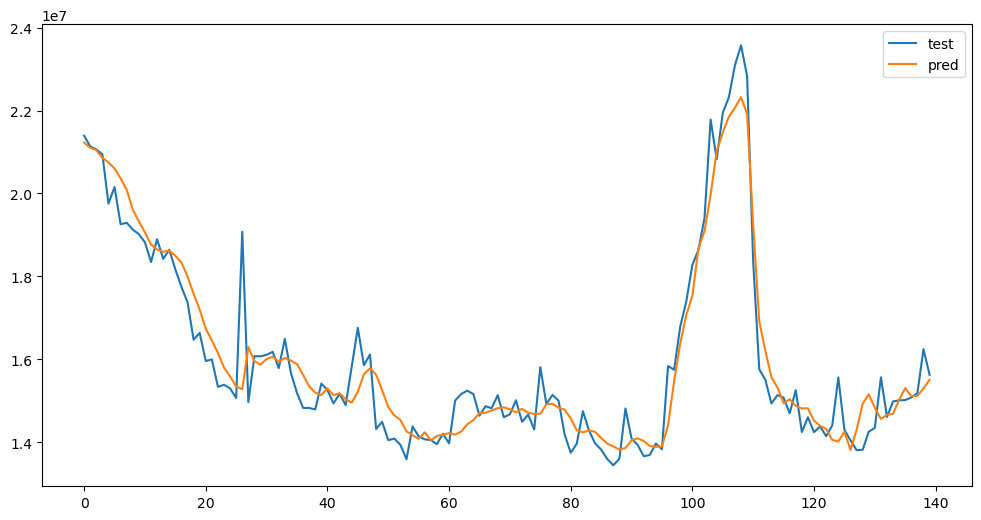

In [127]:
print(data_3["diff_percentage"].describe())

data_3[["test","pred"]].plot(figsize=(12, 6))

In [132]:
# Saving the model

model_3.save('../Saved Models/m_3.keras')

# LSTM of offers : 
<h1 style="color:red;">6</h1>

In [200]:
# Defining the grouped_df to be used here which is the subscription_6 dataframe
grouped_df = subscriptions_6_df

# Adding the lag
for i in range(1, 31):
    grouped_df[f'REVENUE_LAG_{i}'] = grouped_df['REVENUE'].shift(i)
    grouped_df[f'IS_CODE6_ENABLED_{i}'] = grouped_df['IS_CODE6_ENABLED'].shift(i).astype(float)
grouped_df.dropna(inplace=True); grouped_df.reset_index(drop=True,inplace=True)

# Splitting the new lagged dataFrame for training and testing
group_split_value = int(len(grouped_df)*0.8)

df_train = grouped_df.iloc[:group_split_value]
df_test = grouped_df.iloc[group_split_value:]

X_train = df_train.drop(columns=["REPORT_DATE","REVENUE"]).values
y_train = df_train["REVENUE"].values.reshape(-1, 1)

X_test = df_test.drop(columns=["REPORT_DATE","REVENUE"]).values
y_test = df_test["REVENUE"].values.reshape(-1, 1)

In [202]:
# Initialize the scaler for X
scaler_X = MinMaxScaler(feature_range=(0, 1))
X_train_scaled = scaler_X.fit_transform(X_train)
X_test_scaled = scaler_X.transform(X_test)

# Initialize the scaler for y which is not necessary
scaler_y = MinMaxScaler(feature_range=(0, 1))
y_train_scaled = scaler_y.fit_transform(y_train)
y_test_scaled = scaler_y.transform(y_test)

# Saving the scalers
scalers = {'scaler_X': scaler_X, 'scaler_y': scaler_y}

with open('../Scalers/scaler_6.pickle', 'wb') as f:
    pickle.dump(scalers, f)

In [204]:
# Reshaping the data to work with the tensors (3D)
X_train_reshaped = X_train_scaled.reshape((X_train.shape[0], 1, 61))
X_test_reshaped = X_test_scaled.reshape((X_test.shape[0], 1, 61))

In [206]:
# Defining the LSTM model
model_6 = Sequential()
model_6.add(Input(shape=(X_train_reshaped.shape[1], X_train_reshaped.shape[2])))
model_6.add(LSTM(68, return_sequences=True))  
model_6.add(Dropout(0.1))  
model_6.add(LSTM(68, return_sequences=True))  
model_6.add(Dropout(0.1))  
model_6.add(LSTM(68, return_sequences=True))  
model_6.add(Dropout(0.1))  
model_6.add(LSTM(68, return_sequences=True))  
model_6.add(Dropout(0.1))  
model_6.add(LSTM(16, return_sequences=False)) 
model_6.add(Dense(1))
model_6.summary()

Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_30 (LSTM)                       │ (None, 1, 68)               │          35,360 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_24 (Dropout)                 │ (None, 1, 68)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_31 (LSTM)                       │ (None, 1, 68)               │          37,264 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_25 (Dropout)                 │ (None, 1, 68)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_32 (LSTM)                       │ (None, 1, 68)               │          37,264 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_26 (Dropout)                 │ (None, 1, 68)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_33 (LSTM)                       │ (None, 1, 68)               │          37,264 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_27 (Dropout)                 │ (None, 1, 68)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_34 (LSTM)                       │ (None, 16)                  │           5,440 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 1)                   │              17 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 152,609 (596.13 KB)

 Trainable params: 152,609 (596.13 KB)

 Non-trainable params: 0 (0.00 B)

In [226]:
# Compile the model
model_6.compile(optimizer=Adam(learning_rate=0.001), loss='mean_absolute_error')

# Fit the model
history_6 = model_6.fit(X_train_reshaped, y_train_scaled, epochs=400, batch_size=4, validation_data=(X_test_reshaped, y_test_scaled),callbacks=[early_stopping], verbose=1)

Epoch 1/400
134/134 ━━━━━━━━━━━━━━━━━━━━ 13s 16ms/step - loss: 0.0121 - val_loss: 0.0152
Epoch 2/400
134/134 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0118 - val_loss: 0.0124
Epoch 3/400
134/134 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0108 - val_loss: 0.0138
Epoch 4/400
134/134 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0116 - val_loss: 0.0126
Epoch 5/400
134/134 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0116 - val_loss: 0.0179
Epoch 6/400
134/134 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0136 - val_loss: 0.0120
Epoch 7/400
134/134 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0142 - val_loss: 0.0145
Epoch 8/400
134/134 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0130 - val_loss: 0.0126
Epoch 9/400
134/134 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0116 - val_loss: 0.0137
Epoch 10/400
134/134 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0133 - val_loss: 0.0133
Epoch 11/400
134/134 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0132 - val_loss: 0.0148
Epoch 12/400
134/134 ━━━━━━━━━━━━━━━━━━

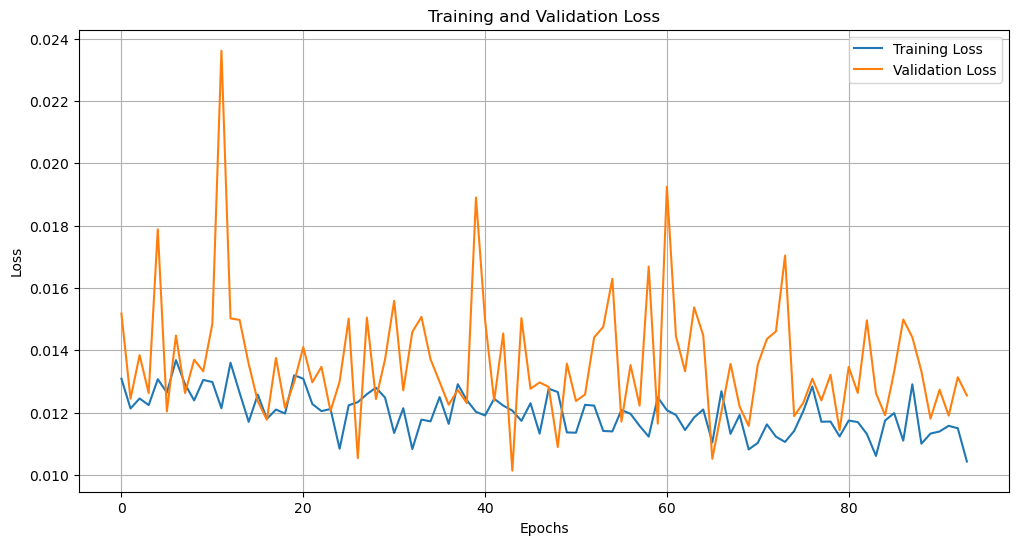

In [227]:
# Checking if there is a overfitting

history_dict = history_6.history
loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']

plt.figure(figsize=(12, 6))
plt.plot(loss_values, label='Training Loss')
plt.plot(val_loss_values, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

In [228]:
# Making the dataframe of predictions

y_pred = scaler_y.inverse_transform(model_6.predict(X_test_reshaped))
abs_diff = np.abs((y_pred.reshape(-1) - y_test.reshape(-1)))

data_6 = pd.DataFrame({
    "test":y_test.reshape(-1),
    "pred":y_pred.reshape(-1),
    "diff_val_by_million":abs_diff/1e6,
    "diff_percentage": abs_diff / y_test.reshape(-1) * 100
})

data_6

5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 275ms/step


,test,pred,diff_val_by_million,diff_percentage
0,26083037.0,28627372.0,2.544335,9.754750
1,28644003.0,28526594.0,0.117409,0.409890
2,27303178.0,27133814.0,0.169364,0.620309
3,26213207.0,27589600.0,1.376393,5.250762
4,26159763.0,27094518.0,0.934755,3.573255
...,...,...,...,...
129,9418133.0,8946461.0,0.471672,5.008126
130,9996085.0,8568583.0,1.427502,14.280611
131,10411340.0,8794573.0,1.616767,15.528904
132,12305902.0,10306558.0,1.999344,16.247033


count    134.000000
mean       8.289302
std       13.448073
min        0.164944
25%        1.929439
50%        5.595126
75%       10.207386
max      132.271103
Name: diff_percentage, dtype: float64


<Axes: >

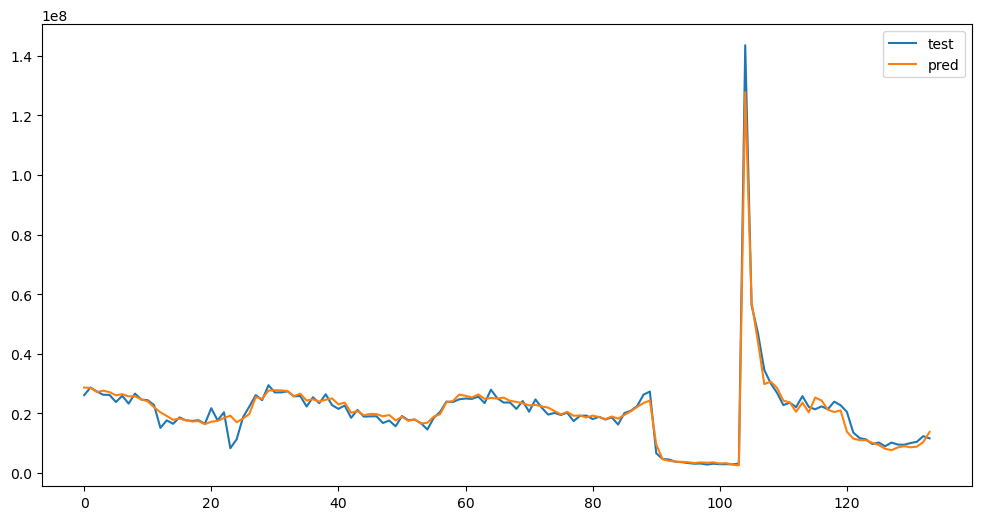

In [229]:
print(data_6["diff_percentage"].describe())

data_6[["test","pred"]].plot(figsize=(12, 6))

In [234]:
# Saving the model

model_6.save('../Saved Models/m_6.keras')

# Fusing all the models into one

<Axes: >

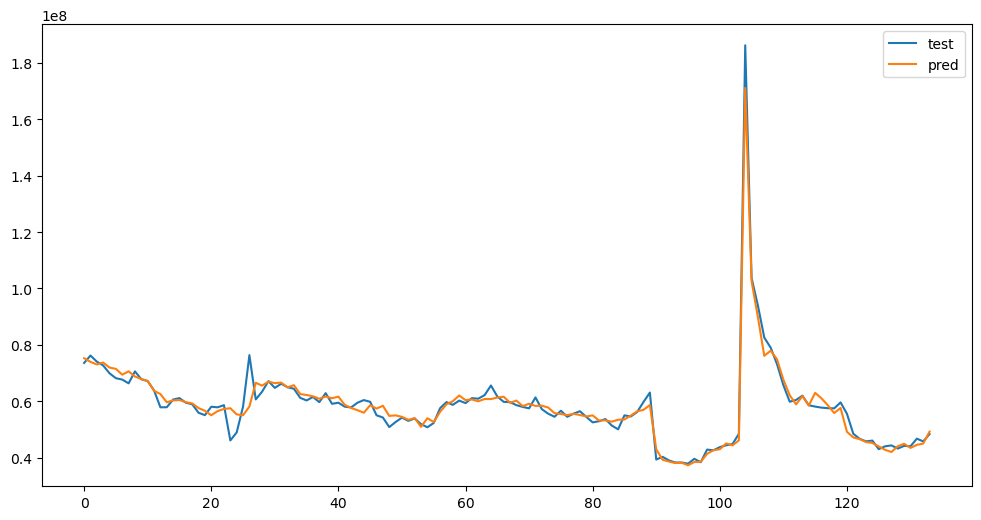

In [237]:
sum_df = pd.DataFrame({
    'test': data_1_2["test"] + data_others["test"] + data_empty["test"] + data_3["test"] + data_6["test"],
    'pred': data_1_2["pred"] + data_others["pred"] + data_empty["pred"] + data_3["pred"] + data_6["pred"]
})

sum_df.plot(figsize=(12, 6))


In [244]:
from sklearn.metrics import mean_absolute_error

mean_absolute_error(sum_df.dropna().test,sum_df.dropna().pred)/sum_df["test"].mean() *100

3.2477894584370817